# Astroplan What's Up Tutorial

In this tutorial we are going to walk through using Astroplan to find out when the Messier objects will be observable  for a location and time of your choosing. 

## Set up observing location:

In [1]:
from astropy.coordinates import EarthLocation
from astroplan import Observer, FixedTarget

In [2]:
# Where are you observing from:
address = '126 5th Ave, New York, New York, 10010'
timezone = "US/Eastern"

Use the `EarthLocation.of_address()` method to obtain your latitude and longitude. You'll need to have internet access to query Google. Then setup an `Astroplan` observer.

In [4]:
location = EarthLocation.of_address(address)

observer = Observer(location=location, timezone=timezone)

NameResolveError: Unable to retrieve coordinates for address '126 5th Ave, New York, New York, 10010'; no results returned

If you have issues getting the location from the this service, you can setup your observer manually.

In [5]:
observer = Observer(location =  EarthLocation.of_site('apo'), timezone='US/Mountain')

Set up observing time range, minimum altitude constraint, at-night constraint and distance from moon constraint. Note that we use the `time` package here because we can put in a generic time without a full date, as in `astropy.time`.

In [15]:
from astroplan import LocalTimeConstraint, MoonSeparationConstraint, AltitudeConstraint, AtNightConstraint
from datetime import time
import astropy.units as u

# Start and stop observing
start_time = time(20, 0)
end_time = time(5, 0)

# Altitude constraint
minimum_altitude = 30 * u.deg

# Minimum distance from moon: 
minimum_moon_separation = 5 * u.deg

constraints = [LocalTimeConstraint(min=start_time, max=end_time), 
               AltitudeConstraint(min=minimum_altitude), 
               AtNightConstraint.twilight_civil(), 
               MoonSeparationConstraint(min=minimum_moon_separation)]

Here we use `astroplan.utils.time_grid_from_range` to make a grid of times with a one hour resolution to check observability against.

In [25]:
from astropy.time import Time

start_date = Time('2018-05-03')
end_date = Time('2018-05-10')

from astroplan.utils import time_grid_from_range

times = time_grid_from_range([start_date, end_date], time_resolution=1*u.hour)

Load in the `json` dictionary of Messier objects and make a list of `astroplan` targets.  

In [26]:
import json
from astropy.coordinates import SkyCoord, Angle
targets_json = json.load(open('messier_targets.json', 'r'))
targets = []

for target in targets_json:
    coord = SkyCoord(ra=Angle(targets_json[target]['RA'], u.hourangle), dec=Angle(targets_json[target]['DEC'], u.degree))
    targets.append(FixedTarget(coord=coord, name=target))

Use `astroplan.constraint` to return boolean arrays for the grid of times, targets and constraints. The full observability array is the boolean product of them all. 

In [27]:
import numpy as np
observability = np.ones((len(targets), len(times))).astype(bool)

#Loop through constraints
for constraint in constraints: 
    observability &= constraint(observer, targets, times, grid_times_targets=True)

Make a list of object names and V magnitudes. Then make a `pandas` table, through astropy, for easy access.

In [28]:
names = [target.name for target in targets]
vmags = [targets_json[target.name]['V'] for target in targets]

import pandas as pd
from astropy.table import Table

table = Table(rows=[vmags], names=names).to_pandas()

Make a column of start times to use as column names and then label columns and rows. Once we have a `pandas` table we can easily filter out any objects that are never observable with the given constraints.

In [35]:
str_times = [t.iso for t in times]
df = pd.DataFrame(data=observability, columns=pd.to_datetime(str_times), index=names)

filter_out_unobservable_targets = df[df.any(axis=1)]

Here we use the boolean sum to order the rows by the the objects that have the most observable time slots. We make a new column by which to sort, and then delete it when we are done with it. 

In [36]:
sums = np.sum(filter_out_unobservable_targets.as_matrix(), axis=1)

filter_out_unobservable_targets['sum'] = sums

filter_out_unobservable_targets.sort_values('sum', ascending=False)
targets_rm_sum = filter_out_unobservable_targets.drop(columns='sum')

C:\Users\alex_\Anaconda3\envs\astroplan-dev\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Here we filter out the time slots which have no targets observable.

In [37]:
a=targets_rm_sum.any(axis=0)

final_table = targets_rm_sum.loc[:,a.values]

In [38]:
final_table

,2018-05-03 03:00:00,2018-05-03 04:00:00,2018-05-03 05:00:00,2018-05-04 03:00:00,2018-05-04 04:00:00,2018-05-04 05:00:00,2018-05-05 02:59:59.999000,2018-05-05 03:59:59.999000,2018-05-05 04:59:59.999000,2018-05-06 02:59:59.999000,...,2018-05-06 04:59:59.999000,2018-05-07 02:59:59.999000,2018-05-07 03:59:59.999000,2018-05-07 04:59:59.999000,2018-05-08 02:59:59.998000,2018-05-08 03:59:59.998000,2018-05-08 04:59:59.998000,2018-05-09 02:59:59.998000,2018-05-09 03:59:59.998000,2018-05-09 04:59:59.998000
M37,True,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
M49,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
M108,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
M67,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,False,True,True,False
M91,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
M60,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
M85,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
M66,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
M94,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
M96,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True


We can make a very basic plot using MatPlotLib imshow:

Text(0.5,0,'Time from UTC 2018-05-03 00:00:00.000 [hrs]')

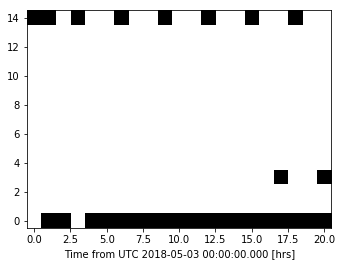

In [44]:
%matplotlib inline
import matplotlib.pyplot as plt

arr_final_table = final_table.as_matrix()

plt.imshow(arr_final_table, cmap=plt.cm.Greys_r, origin='lower')
plt.xlabel('Time from UTC {0} [hrs]'.format(times[0].iso))

But it's hard to make out any details, we really need to filter out any objects with a magnitude we can't observe.

In [45]:
sums = np.sum(filter_out_unobservable_targets.as_matrix(), axis=1)

filter_out_unobservable_targets['sum'] = sums

filter_out_unobservable_targets.sort_values('sum', ascending=False)
targets_rm_sum = filter_out_unobservable_targets.drop(columns='sum')
final_table = targets_rm_sum.loc[:,a.values]

C:\Users\alex_\Anaconda3\envs\astroplan-dev\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Here we make a more advanced plot using subplots for each day all sharing a common y-axis and with a bit of color to help identify correlating objects. (and adding in some retro 8-bit charm)

C:\Users\alex_\Anaconda3\envs\astroplan-dev\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


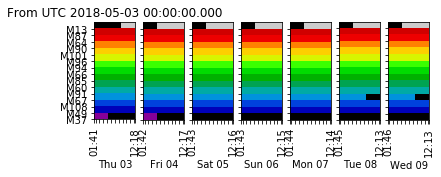

In [47]:
import matplotlib.dates as mdates
import datetime

sums = np.sum(filter_out_unobservable_targets.as_matrix(), axis=1)

filter_out_unobservable_targets['sum'] = sums

filter_out_unobservable_targets.sort_values('sum', ascending=False)
targets_rm_sum = filter_out_unobservable_targets.drop(columns='sum')

# Reduce number of rows
final_table = final_table[0:15]

# To seperate by nights
days = time_grid_from_range([start_date, end_date], time_resolution=1*u.day)
twilights = observer.twilight_evening_civil(time=days)
sunrises = observer.sun_rise_time(time=twilights, which='next')
sunsets = observer.sun_set_time(time=twilights, which='previous')

# Make subployts for each night
fig, lis_ax = plt.subplots(1, len(twilights), sharey=True)

# Get a new df per night and plot:
for i, twilight in enumerate(list(twilights)):
    # Use truncation to get only columns after sunset and before sunrise
    df_night = final_table.truncate(sunsets[i].to_datetime(), sunrises[i].to_datetime(), axis=1)
    
    # Color this
    arr_night_col = df_night.as_matrix()
    arr_night_col = arr_night_col * np.linspace(10,100, arr_night_col.shape[0]).reshape((arr_night_col.shape[0],1))
    
    # Make subplot for this night
    lis_ax[i].imshow(arr_night_col, cmap='nipy_spectral', origin='lower',
                     extent=(
                             #mdates.date2num(df_night.columns[0]),
                             #mdates.date2num(df_night.columns[-1]),
                             mdates.date2num(sunsets[i].datetime),
                             mdates.date2num(sunrises[i].datetime),
                             0, len(final_table.index.values)),
                             aspect=0.07)
    
    # Label and ticks for x-axis
    lis_ax[i].set_xlabel(twilight.datetime.strftime('%a %d'))
    lis_xticks = [ sunsets[i].datetime ]
    lis_xlabels = [sunsets[i].datetime.strftime('%H:%M')]
    dt_tick = datetime.datetime(sunsets[i].datetime.year,
                                sunsets[i].datetime.month,
                                sunsets[i].datetime.day,
                                sunsets[i].datetime.hour) + datetime.timedelta(hours=1)
    while dt_tick < sunrises[i].datetime:
        lis_xticks.append(dt_tick)
        lis_xlabels.append('')
        dt_tick = dt_tick + datetime.timedelta(hours=1)
    lis_xticks.append(sunrises[i].datetime)
    lis_xlabels.append(sunrises[i].datetime.strftime('%H:%M'))
    
    lis_ax[i].set_xticks(mdates.date2num(lis_xticks))
    lis_ax[i].set_xticklabels(lis_xlabels, rotation='vertical')
    """
    lis_ax[i].set_xticks([mdates.date2num(sunsets[i].datetime),
                         #mdates.date2num(twilights[i].datetime),
                         mdates.date2num(sunrises[i].datetime)])
    lis_ax[i].set_xticklabels([sunsets[i].datetime.strftime('%H:%M'),
                                #twilights[i].datetime.strftime('%H:%M'),
                                sunrises[i].datetime.strftime('%H:%M')],
                               rotation='vertical')
    """
    # Set minor ticks for each hour
    #lis_ax[i].xaxis.set_minor_locator()
#
lis_ax[0].set_title('From UTC {0}'.format(times[0].iso))    

# Tweak the common y-axis
int_skip_labels = 1
lis_ax[0].set_yticks(range(0,len(final_table.index.values),int_skip_labels))
lis_ax[0].set_yticklabels(final_table.index.values[::int_skip_labels])

# Show the plot
#fig.savefig('7-Day Objects 15 targets.png', dpi=900, bbox_inches='tight')
plt.show()